## Paper Result Verification (Practice with PySINDy)

In [4]:
# Import needed packages
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from pysindy.utils import linear_damped_SHO
from pysindy.utils import cubic_damped_SHO
from pysindy.utils import linear_3D
from pysindy.utils import hopf
from pysindy.utils import lorenz

import pysindy as ps

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

#### Linear 2D ODE (Damped Harmonic Oscillator)

Generate training data for the following linear system of differential equations with initial condtion $(2,0)$.

$$
\frac{d}{dt}\begin{bmatrix} x \\ y \end{bmatrix}= \begin{bmatrix}-0.1 & 2\\ -2 & -0.1 \end{bmatrix} \begin{bmatrix} x\\ y \end{bmatrix}
$$

In [38]:
# Generate training data

dt = 0.01
t_train = np.arange(0, 25, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [2, 0]
x_train = solve_ivp(linear_damped_SHO, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T

Now we are going to fit a SINDy model to the training data.

In [39]:
# Fit the model

poly_order = 5 #assuming this is highest polynomial order consdiered in candidate functions matrix
threshold = 0.05 #lambda value in sparse regression optimization problem
feat_names = ['x', 'y']

#STLSQ: sequential threshold least square optimizer
#Using Polynomial Library up to polynomial order determined above
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
    differentiation_method=ps.FiniteDifference(order=2),
    feature_names=feat_names
)
model.fit(x_train, t=dt)
model.print()

(x)' = -0.100 x + 2.000 y
(y)' = -2.000 x + -0.100 y


Looks great!

The learned model can be used to evolve initial conditions forward in time.

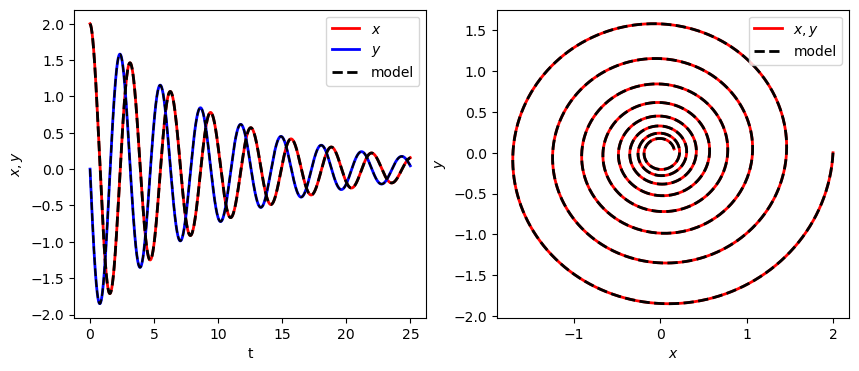

In [40]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$", **plot_kws)
axs[0].plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x,y$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x,y$", **plot_kws)
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x$", ylabel="$y$")
fig.show()
plt.savefig('twodlinosc.png')

In [41]:
# Evolve the @D linear ODE equations in time using a different initial condition
t_test = np.arange(0, 25, dt)
x0_test = [2,4]
t_test_span = (t_test[0], t_test[-1])
x_test = solve_ivp(
    linear_damped_SHO, t_test_span, x0_test, t_eval=t_test, **integrator_keywords
).y.T

# Compare SINDy-predicted derivatives with finite difference derivatives
print("Model score: %f" % model.score(x_test, t=dt))

Model score: 1.000000


#### Cubic 2D ODE (Nonlinear 2D Damped Harmonic Oscillator)

Generate training data for the following nonlinear system of differential equations with initial condtion $(2,0)$.

$$
\frac{d}{dt}\begin{bmatrix} x \\ y \end{bmatrix}= \begin{bmatrix}-0.1 & 2\\ -2 & -0.1 \end{bmatrix} \begin{bmatrix} x^3\\ y^3 \end{bmatrix}
$$

In [46]:
# Generate training data

dt = 0.01
t_train = np.arange(0, 25, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [2, 0]
x_train = solve_ivp(cubic_damped_SHO, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T

In [47]:
# Fit the model

poly_order = 5
threshold = 0.05
feat_names = ['x', 'y']

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
    feature_names=feat_names
)
model.fit(x_train, t=dt)
model.print()

(x)' = -0.100 x^3 + 1.999 y^3
(y)' = -1.999 x^3 + -0.100 y^3


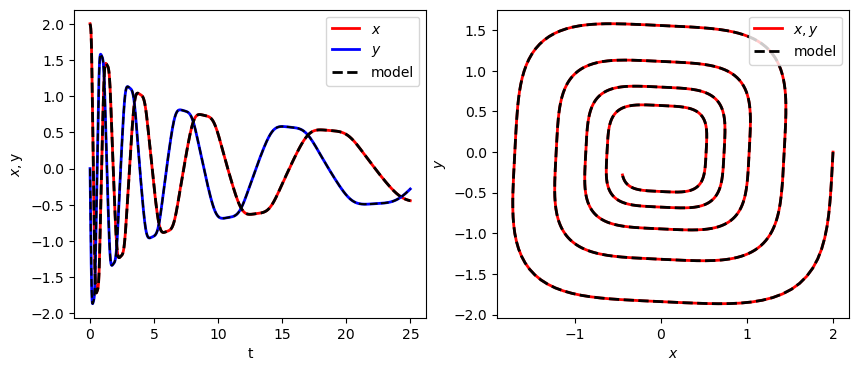

In [48]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$", **plot_kws)
axs[0].plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x,$y")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x,y$", **plot_kws)
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x$", ylabel="$y$")
fig.show()
plt.savefig('twodnonlinosc.png')

In [49]:
# Evolve the @D linear ODE equations in time using a different initial condition
t_test = np.arange(0, 25, dt)
x0_test = [2,4]
t_test_span = (t_test[0], t_test[-1])
x_test = solve_ivp(
    cubic_damped_SHO, t_test_span, x0_test, t_eval=t_test, **integrator_keywords
).y.T

# Compare SINDy-predicted derivatives with finite difference derivatives
print("Model score: %f" % model.score(x_test, t=dt))

Model score: 0.999188


#### Linear 3D ODE

Generate training data for the following nonlinear system of differential equations with initial condtion $(2,0)$.

$$
\frac{d}{dt}\begin{bmatrix} x \\ y \\ z \end{bmatrix}= \begin{bmatrix}-0.1 & -2 & 0\\ 2 & -0.1 & 0 \\ 0 & 0 & -0.3\end{bmatrix} \begin{bmatrix} x\\ y \\ z\end{bmatrix}
$$ 

In [56]:
# Generate training data

dt = .01
t_train = np.arange(0, 50, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [2, 0, 1]
x_train = solve_ivp(linear_3D, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T

In [70]:
# Fit the model

poly_order = 5
threshold = 0.01
feat_names = ['x','y','z']

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
    feature_names = feat_names
)
model.fit(x_train, t=dt)
model.print()

(x)' = -0.100 x + 2.000 y
(y)' = -2.000 x + -0.100 y
(z)' = -0.300 z


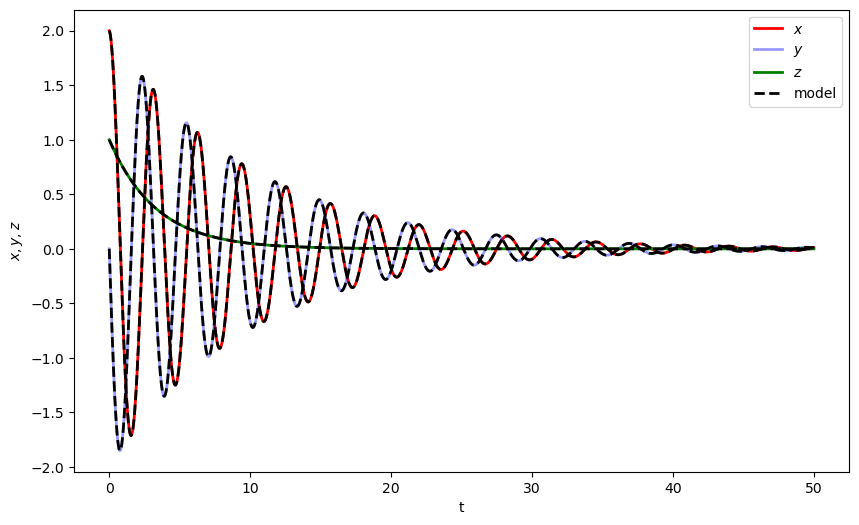

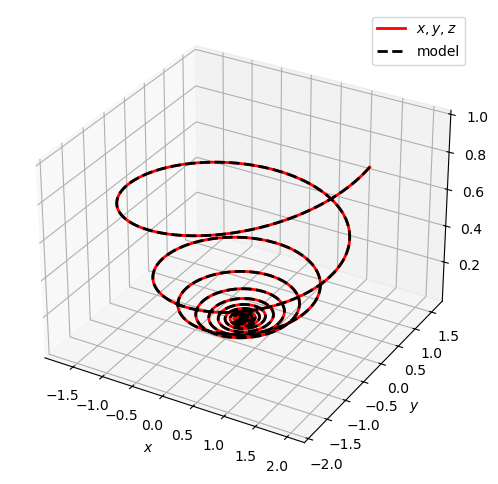

In [72]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)

fig = plt.figure(figsize=(10, 6))
plt.plot(t_train, x_train[:, 0], "r", label="$x$", **plot_kws)
plt.plot(t_train, x_train[:, 1], "b", label="$y$", alpha=0.4, **plot_kws)
plt.plot(t_train, x_train[:, 2], "g", label="$z$", **plot_kws)
plt.plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
plt.plot(t_train, x_sim[:, 1], "k--", **plot_kws)
plt.plot(t_train, x_sim[:, 2], "k--", **plot_kws)
plt.legend()
plt.xlabel("t")
plt.ylabel("$x,y,z$")
fig.show()
plt.savefig('threedlin1.png')

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x,y,z$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
ax.legend()
fig.show()
plt.savefig('threedlin2.png')

#### Lorenz System (Nonlinear ODE)

Given by: 
$$
\begin{align}
\dot{x}&=\sigma(y-x)\\
\dot{y}&=x(\rho-z)-y\\
\dot{z}&=xy-\beta z
\end{align}
$$

In this example we will use $\sigma = 10, \rho = 28, \beta = \frac{8}{3}$ and use the initial condition $(-8,8,27)$.
For this example we also collect measurements of derivatives of state variables $(\dot{x}, \dot{y}, \dot{z})$.

In [5]:
# Generate training data

dt = 0.001
t_train = np.arange(0, 100, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T
x_dot_train_measured = np.array(
    [lorenz(0, x_train[i]) for i in range(t_train.size)]
)

##### Measure state $x$ and derivative $\dot{x}$ & increase level of noise $\eta$ are added to derivatives

In [6]:
# Fit the models and simulate

poly_order = 5
threshold = 0.05

noise_levels = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.00]

models = []
t_sim = np.arange(0, 20, dt)
x_sim = []
for eps in noise_levels:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.PolynomialLibrary(degree=poly_order),
    )
    model.fit(
        x_train,
        t=dt,
        x_dot=x_dot_train_measured
        + np.random.normal(scale=eps, size=x_train.shape),
        quiet=True,
    )
    models.append(model)
    x_sim.append(model.simulate(x_train[0], t_sim))

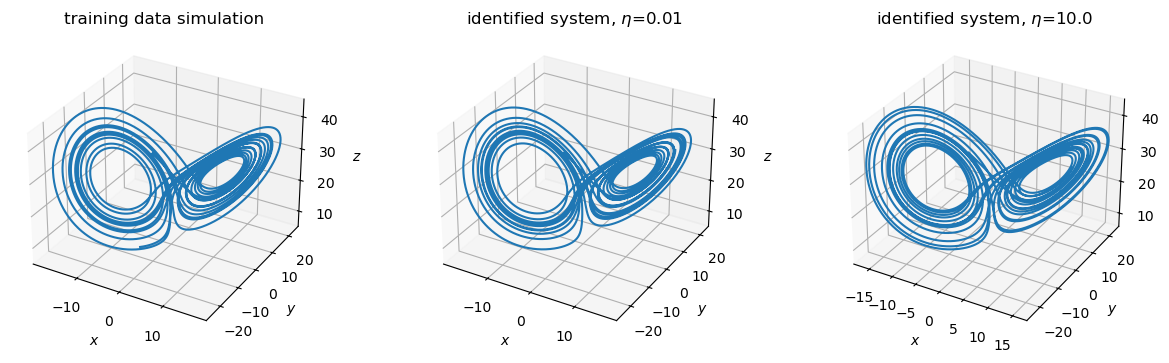

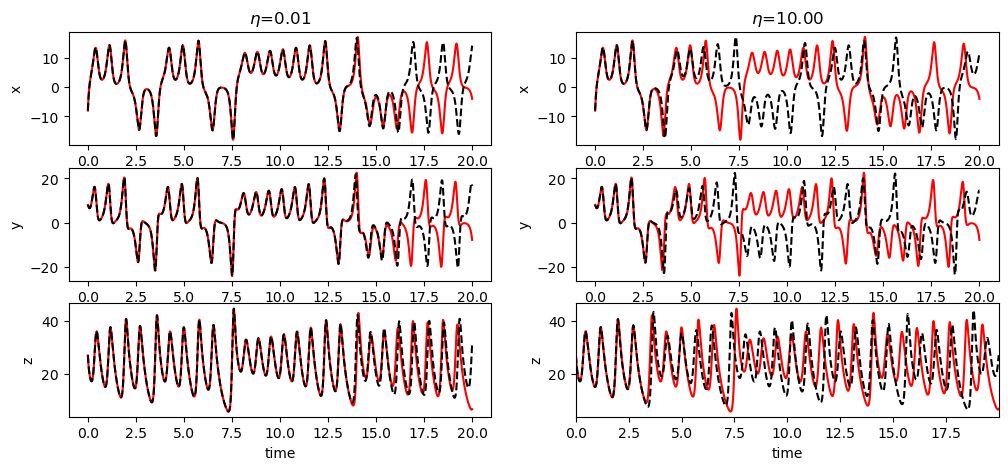

In [7]:
# Plot results

fig = plt.figure(figsize=(15, 4))

ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_train[: t_sim.size, 0],
    x_train[: t_sim.size, 1],
    x_train[: t_sim.size, 2]
)
plt.title("training data simulation")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 2
ax = fig.add_subplot(132, projection="3d")
ax.plot(
    x_sim[model_idx][:, 0], 
    x_sim[model_idx][:, 1], 
    x_sim[model_idx][:, 2]
)
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 5
ax = fig.add_subplot(133, projection="3d")
ax.plot(
    x_sim[model_idx][:, 0], 
    x_sim[model_idx][:, 1], 
    x_sim[model_idx][:, 2]
)
plt.title(f"identified system, $\eta$={noise_levels[model_idx]}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()
plt.margins(x=0)
plt.savefig('lorenz1.png')

fig = plt.figure(figsize=(12, 5))

model_idx = 2
ax = fig.add_subplot(321)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(323)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

ax = fig.add_subplot(325)
ax.plot(t_sim, x_train[: t_sim.size, 2], "r")
ax.plot(t_sim, x_sim[model_idx][:, 2], "k--")
plt.xlabel("time")
plt.ylabel("z")

model_idx = 5
ax = fig.add_subplot(322)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(324)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

ax = fig.add_subplot(326)
ax.plot(t_sim, x_train[: t_sim.size, 2], "r")
ax.plot(t_sim, x_sim[model_idx][:, 2], "k--")
plt.xlabel("time")
plt.ylabel("z")

fig.show()
plt.margins(x=0)
plt.savefig('lorenz2.png')

##### Measure state $x$ and compute derivative (centered difference scheme) $\dot{x}$ & varioius levels of noise are added to state

In [8]:
# Fit the models and simulate

noise_levels = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]

models_noD = []
t_sim = np.arange(0, 20, dt)
x_sim_noD = []
for eps in noise_levels:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.PolynomialLibrary(degree=poly_order),
    )
    model.fit(x_train + np.random.normal(scale=eps, size=x_train.shape),
              t=dt, quiet=True)
    models_noD.append(model)
    x_sim_noD.append(model.simulate(x_train[0], t_sim))

In [9]:
noise_levels_2 = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]
models_sfd = []
x_sim_sfd = []
for eps in noise_levels_2:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.PolynomialLibrary(degree=poly_order),
        differentiation_method = ps.SmoothedFiniteDifference(),
    )
    model.fit(x_train + np.random.normal(scale=eps, size=x_train.shape),
              t=dt, quiet=True)
    models_sfd.append(model)
    x_sim_sfd.append(model.simulate(x_train[0], t_sim))
    print(f"Model {eps} is done")

Model 0.0001 is done
Model 0.001 is done
Model 0.01 is done
Model 0.1 is done
Model 1.0 is done


Plot the error as a function of time for varying levels of noise.

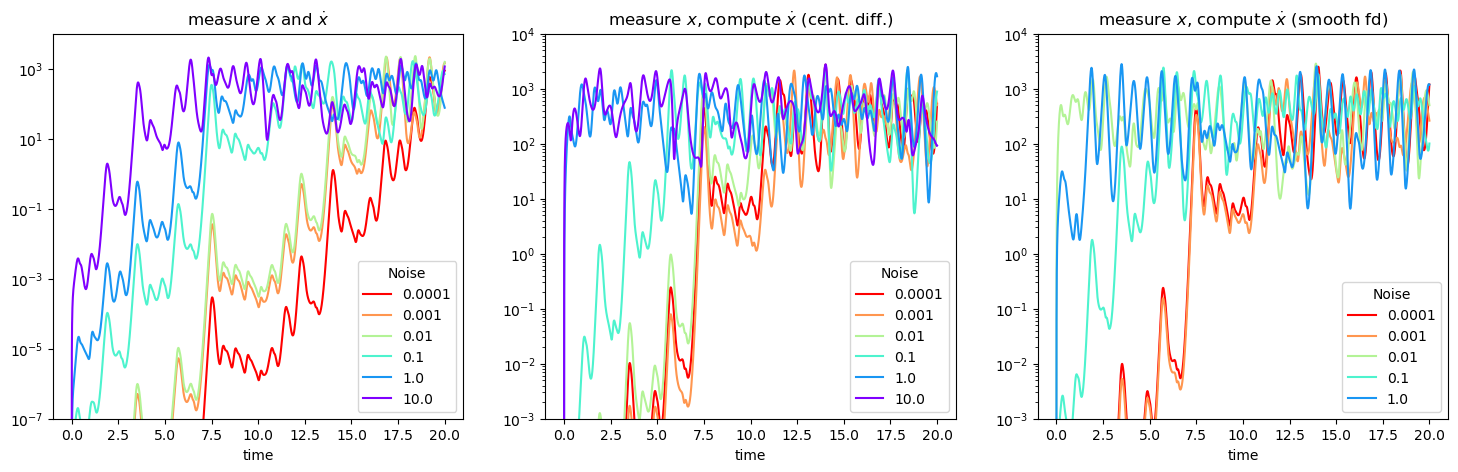

In [12]:
colors = rainbow(np.linspace(1, 0, len(models)))

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, x in enumerate(x_sim):
    axs[0].semilogy(
        t_sim,
        np.sum((x - x_train[: t_sim.size]) ** 2, axis=1),
        color=colors[i],
        label=noise_levels[i],
    )
axs[0].set(xlabel="time", title="measure $x$ and $\dot{x}$")
axs[0].legend(title="Noise")
axs[0].set_ylim(1e-7, 1e4)

for i, x in enumerate(x_sim_noD):
    axs[1].semilogy(
        t_sim,
        np.sum((x - x_train[: t_sim.size]) ** 2, axis=1),
        color=colors[i],
        label=noise_levels[i],
    )

axs[1].set(xlabel="time", title="measure $x$, compute $\dot{x}$ (cent. diff.)")
axs[1].legend(title="Noise")
axs[1].set_ylim(1e-3, 1e4)

for i, x in enumerate(x_sim_sfd):
    axs[2].semilogy(
        t_sim,
        np.sum((x - x_train[: t_sim.size]) ** 2, axis=1),
        color=colors[i],
        label=noise_levels[i],
    )

axs[2].set(xlabel="time", title="measure $x$, compute $\dot{x}$ (smooth fd)")
axs[2].legend(title="Noise")
axs[2].set_ylim(1e-3, 1e4)

fig.show()
plt.savefig('lorenz3.png')